In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import datetime
import glob
import os
import peakutils
import datetime
import warnings
import logging
from jupyterthemes import jtplot

from ali.ali_sw import *
from ali.ali_peaks import *
from ali.recovery_times import *
from qmb.qmb_sw import *

In [2]:
jtplot.style('default', grid=False)
logging.getLogger().setLevel(logging.CRITICAL)

In [33]:
def coating_mass(dfq : pd.DataFrame, upCut: int = 10):
    """Compute frequency shift and coating mass in QMB deposition"""
    Fq = 6045000 # Blank frequency [Hz]
    Nat = 166100 # Frequency constant [Hz*cm]
    pq = 2.649 # Single crystal quartz density [g/cm^3]
    pf = 3.2 # Film density for Ba(ClO_4)_2 [g/cm^3]
    K = Nat * pq / Fq**2   # Empirical constant [g/(cm^2 * Hz)]

    
    d_qc = 0.8 # quartz crystal diameter [cm]
    A_q = np.pi*(d_qc/2)**2  # quartz crystal area [cm^2]
    mq = K * Fq * A_q   # Quartz crystal mass [g] (reference)
    
    deltaF = []
    mL = []
    for pulse in dfq:        
        try:
            tend = dfq[pulse].iloc[:upCut].idxmin()
            tstart = dfq[pulse].iloc[:tend].idxmax()
            freqstart = dfq[pulse].iloc[tstart]
            freqend = dfq[pulse].iloc[tend]
            dF = freqstart - freqend
            deltaF.append(dF)

            mL.append(mq * dF/freqstart)
            continue
        except ValueError:
            print(pulse + ' is too short with upCut ' + str(upCut))
            continue
        
    return mL, deltaF

def plot_ali_qmb_pulses(dfp: pd.DataFrame, dfq: pd.DataFrame, ax = None, tfraction = None):
    if ax == None: ax = plt.gca()
    ax.plot(dfq.timestamp, dfq.frequency)
    ax.tick_params(axis='y', labelcolor='b')
    ax.set_ylabel('f [Hz]')
    
    if tfraction is not None:
        ax.set_xlim(dfq.timestamp[0], tfraction)
    
    ax2 = plt.twinx(ax)
    ax2.plot(dfp.datetime, dfp.p_chamber, '-r')
    ax2.set_ylabel('p$_{chamb}$ [mbar]')
    ax2.set_yscale('log')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.gcf().autofmt_xdate()

# ALI on QMC experiments: z position test, Ba(ClO$_4$)$_2$ 0.5 mM 

In [9]:
ali_path = '/Users/pabloherrero/sabat/ali_data/Ba(ClO4)2_shooting/ALI_QMB_test/zdrive_test/*'
qmb_path = '/Users/pabloherrero/sabat/qmc_data/ALI_QMB_BaClO42_test/zdrive_test/*'
qmbFiles = glob.glob(qmb_path)
qmbFiles.sort()
aliFiles = glob.glob(ali_path)
aliFiles.sort()

qmbFiles, aliFiles

(['/Users/pabloherrero/sabat/qmc_data/ALI_QMB_BaClO42_test/zdrive_test/RUN#00003_z45mm_200mbar_50ms.txt',
  '/Users/pabloherrero/sabat/qmc_data/ALI_QMB_BaClO42_test/zdrive_test/RUN#00009_z49mm_200mbar_50ms.txt',
  '/Users/pabloherrero/sabat/qmc_data/ALI_QMB_BaClO42_test/zdrive_test/RUN#00010_z53mm_200mbar_50ms.txt',
  '/Users/pabloherrero/sabat/qmc_data/ALI_QMB_BaClO42_test/zdrive_test/RUN#00011_z57mm_200mbar_50ms.txt',
  '/Users/pabloherrero/sabat/qmc_data/ALI_QMB_BaClO42_test/zdrive_test/RUN#00012_z61mm_200mbar_50ms.txt',
  '/Users/pabloherrero/sabat/qmc_data/ALI_QMB_BaClO42_test/zdrive_test/RUN#00013_z65mm_200mbar_50ms.txt',
  '/Users/pabloherrero/sabat/qmc_data/ALI_QMB_BaClO42_test/zdrive_test/RUN#00014_z69mm_200mbar_50ms.txt',
  '/Users/pabloherrero/sabat/qmc_data/ALI_QMB_BaClO42_test/zdrive_test/RUN#00015_z73mm_200mbar_50ms.txt'],
 ['/Users/pabloherrero/sabat/ali_data/Ba(ClO4)2_shooting/ALI_QMB_test/zdrive_test/15052020_BaClO42_qmb_z45mm_200mbar_50ms_20pulse',
  '/Users/pabloherr

## Importing all data

In [10]:
dfps = [load_raw_ali_df(f) for f in aliFiles]
dfqs = [import_qmb_data(f) for f in qmbFiles]

## Split RUN#00008: appended RUN#00009 to it by mistake

In [6]:
aliFiles[1], qmbFiles[2]

('/Users/pabloherrero/sabat/ali_data/Ba(ClO4)2_shooting/ALI_QMB_test/zdrive_test/18052020_BaClO42_qmb_z49mm_200mbar_50ms_20pulse',
 '/Users/pabloherrero/sabat/qmc_data/ALI_QMB_BaClO42_test/zdrive_test/RUN#00009_z49mm_200mbar_50ms.txt')

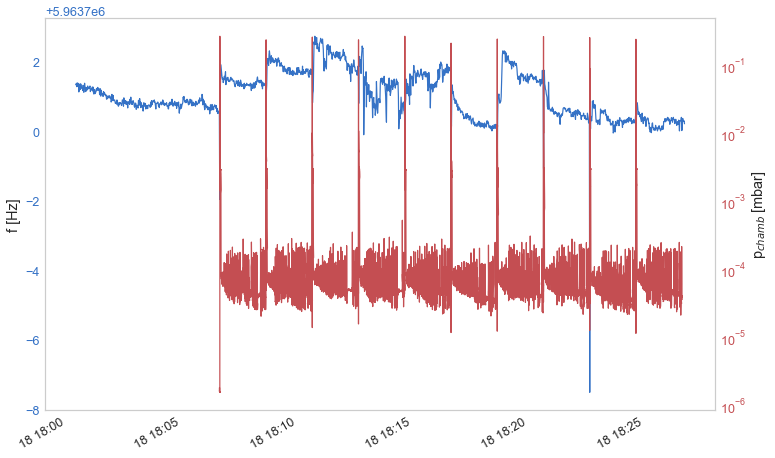

In [7]:
dfp = load_raw_ali_df(aliFiles[1])
dfq = import_qmb_data(qmbFiles[2])
fig = plt.figure(figsize=(12,8))
plot_ali_qmb_pulses(dfp, dfq)

## Drop QMB data until first injection

In [11]:
dfq_short = []
for dfp, dfq in zip(dfps, dfqs):
    minAli = findTroughsFast(dfp)
    firstP = dfp.datetime[minAli[0]]
    dfq_sh = dfq[dfq.timestamp >= firstP]
    dfq_sh.reset_index(drop=True, inplace=True)
    dfq_short.append(dfq_sh)

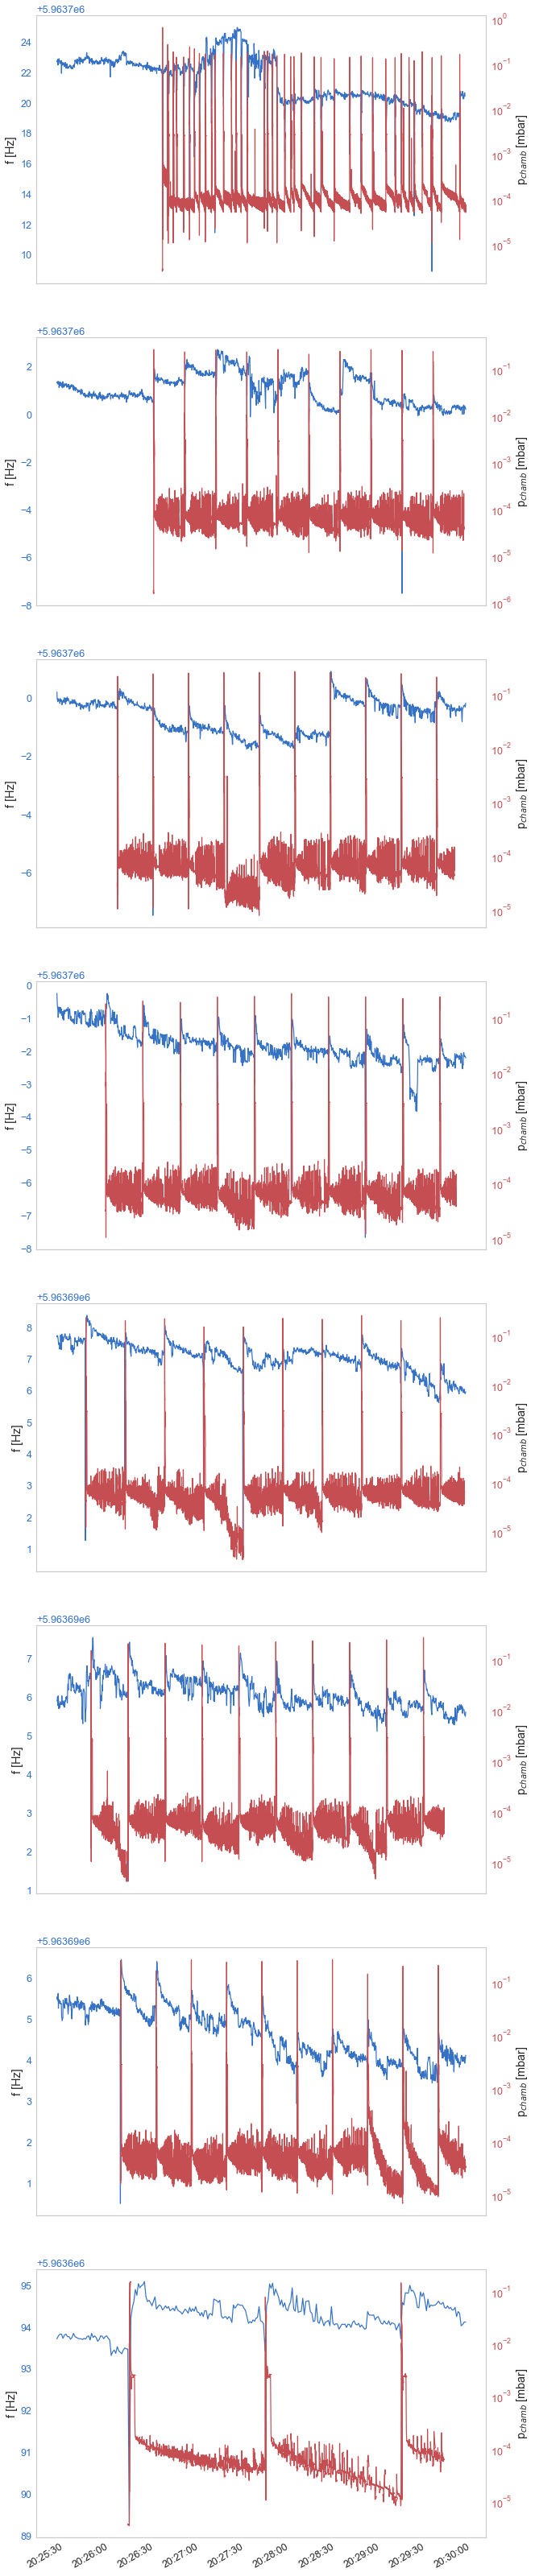

In [11]:
fig, ax = plt.subplots(len(dfqs), figsize=(10,8 * len(dfqs)))
for i,(dfp, dfq) in enumerate(zip(dfps, dfqs)):
    plot_ali_qmb_pulses(dfp, dfq, ax=ax[i])

## Extract QMB pulses

In [12]:
dfqp = []
for dfp, dfq in zip(dfps, dfqs):
    minAli = findTroughsFast(dfp)
    minQmb = qmb_troughs_asALI(dfq, dfp, minAli)
    dfqp.append(extractQMBPeaks(dfq, minQmb))

(0, 20)

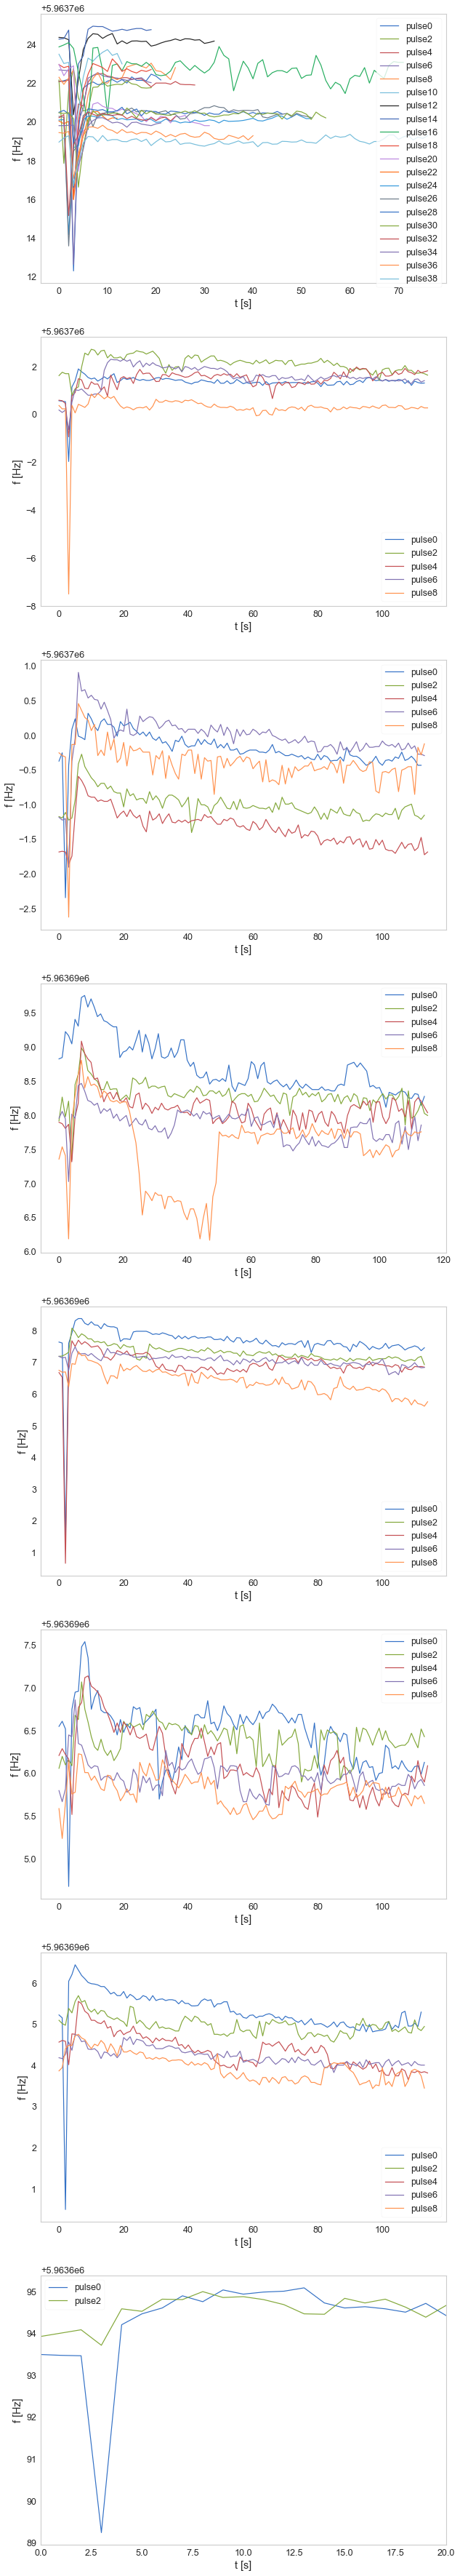

In [13]:
fig, ax = plt.subplots(len(dfqp), figsize=(10,8 * len(dfqs)))
for i,dfq in enumerate(dfqp):
    overplot_QMB_pulses(dfq, every=2, ax=ax[i])
plt.xlim(0, 20)

## Get ∆m from ∆f

In [14]:
mL, dF = [], []
for dfq in dfqp:
    ml, df = coating_mass(dfq)
    mL.append((np.average(ml), np.std(ml)))
    dF.append((np.average(df), np.std(df)))

pulse1 is too short with upCut 10
pulse0 is too short with upCut 10
pulse2 is too short with upCut 10
pulse9 is too short with upCut 10
pulse2 is too short with upCut 10
pulse8 is too short with upCut 10


In [15]:
mL

[(3.2692745345981594e-08, 1.5903890806595604e-08),
 (1.253365259993554e-08, 1.2942514359857684e-08),
 (1.2429361679605466e-08, 1.1890785437945109e-08),
 (1.2958332017378358e-08, 1.1158705063715796e-08),
 (1.764559027735417e-08, 1.578352696036155e-08),
 (6.932471238295282e-09, 8.629656624408662e-09),
 (5.24877479669455e-09, 8.613559539231527e-09),
 (1.0920180548713473e-08, 1.0750788356629157e-08)]

In [16]:
dF

[(5.328974358904629, 2.5923623469228847),
 (2.0429999998770656, 2.109644756852502),
 (2.0259999999776483, 1.9382115467618246),
 (2.1122222221973868, 1.818881083594956),
 (2.876249999855645, 2.572731707340646),
 (1.1299999998882413, 1.4066429696200213),
 (0.8555555557832122, 1.4040189229930742),
 (1.7800000002607703, 1.752388845572739)]

In [52]:
mmL = np.matrix(mL)
mdF = np.matrix(dF)


In [29]:
zpos = np.arange(45,77,4)
zpos, len(zpos)

(array([45, 49, 53, 57, 61, 65, 69, 73]), 8)

Text(0.5, 1.0, 'ALI+QMB position test')

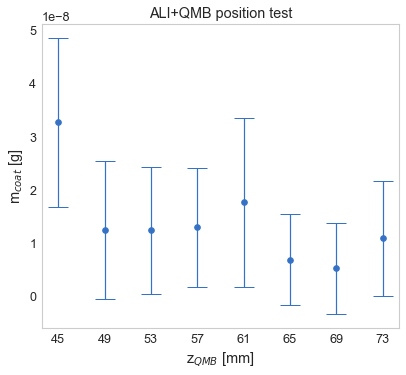

In [51]:
plt.errorbar(zpos, mmL[:,0], mmL[:,1], fmt='o', capsize=10, mew=1)
plt.ylabel('m$_{coat}$ [g]')
plt.xlabel('z$_{QMB}$ [mm]')
plt.xticks(zpos);
plt.title('ALI+QMB position test')

Text(0.5, 1.0, 'ALI+QMB position test')

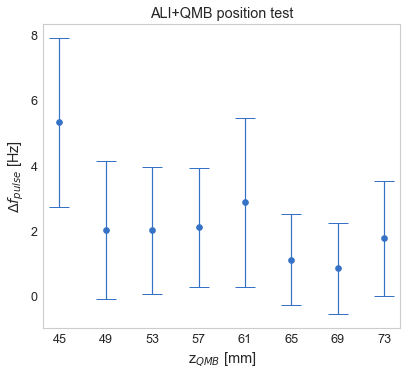

In [55]:
plt.errorbar(zpos, mdF[:,0], mdF[:,1], fmt='o', capsize=10, mew=1)
plt.ylabel('$\Delta f_{pulse}$ [Hz]')
plt.xlabel('z$_{QMB}$ [mm]')
plt.xticks(zpos);
plt.title('ALI+QMB position test')

# ALI on QMC experiments: Ba(ClO$_4$)$_2$ 0.5 mM 

In [122]:
ali_path = '/Users/pabloherrero/sabat/ali_data/Ba(ClO4)2_shooting/ALI_QMB_test/15*'
qmb_path = '/Users/pabloherrero/sabat/qmc_data/ALI_QMB_BaClO42_test/*.txt'
qmbFiles = glob.glob(qmb_path)
qmbFiles.sort()
aliFiles = glob.glob(ali_path)
aliFiles.sort()

qmbFiles, aliFiles

(['/Users/pabloherrero/sabat/qmc_data/ALI_QMB_BaClO42_test/RUN#00002_1bar_50ms.txt',
  '/Users/pabloherrero/sabat/qmc_data/ALI_QMB_BaClO42_test/RUN#00003_200mbar_50ms.txt',
  '/Users/pabloherrero/sabat/qmc_data/ALI_QMB_BaClO42_test/RUN#00004_200mbar_500ms.txt',
  '/Users/pabloherrero/sabat/qmc_data/ALI_QMB_BaClO42_test/RUN#00005_1bar_500ms.txt'],
 ['/Users/pabloherrero/sabat/ali_data/Ba(ClO4)2_shooting/ALI_QMB_test/15052020_BaClO42_qmb_test1_1000mbar_50ms_100pulse',
  '/Users/pabloherrero/sabat/ali_data/Ba(ClO4)2_shooting/ALI_QMB_test/15052020_BaClO42_qmb_test2_200mbar_50ms_20pulse',
  '/Users/pabloherrero/sabat/ali_data/Ba(ClO4)2_shooting/ALI_QMB_test/15052020_BaClO42_qmb_test3_200mbar_500ms_40pulse',
  '/Users/pabloherrero/sabat/ali_data/Ba(ClO4)2_shooting/ALI_QMB_test/15052020_BaClO42_qmb_test4_1000mbar_500ms_40pulse'])

## Importing all data

In [123]:
dfps = [load_raw_ali_df(f) for f in aliFiles]
dfqs = [import_qmb_data(f) for f in qmbFiles]

## Drop QMB data until first injection

In [11]:
dfq_short = []
for dfp, dfq in zip(dfps, dfqs):
    minAli = findTroughsFast(dfp)
    firstP = dfp.datetime[minAli[0]]
    dfq_sh = dfq[dfq.timestamp >= firstP]
    dfq_sh.reset_index(drop=True, inplace=True)
    dfq_short.append(dfq_sh)

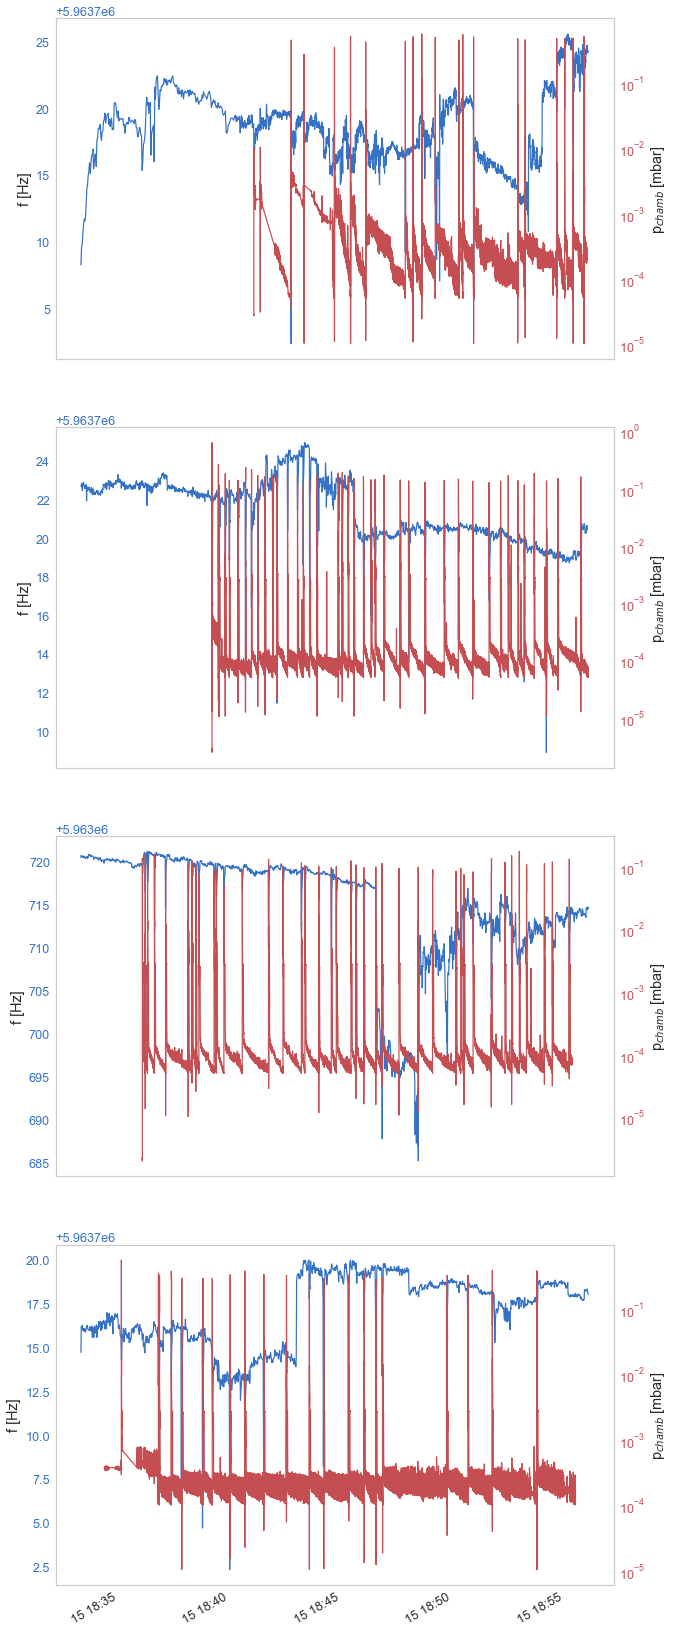

In [124]:
fig, ax = plt.subplots(len(dfqs), figsize=(10,8 * len(dfqs)))
for i,(dfp, dfq) in enumerate(zip(dfps, dfqs)):
    plot_ali_qmb_pulses(dfp, dfq, ax=ax[i])

## Extract QMB pulses

In [125]:
dfqp = []
for dfp, dfq in zip(dfps, dfqs):
    minAli = findTroughsFast(dfp)
    minQmb = qmb_troughs_asALI(dfq, dfp, minAli, offset=7)
    dfqp.append(extractQMBPeaks(dfq, minQmb))

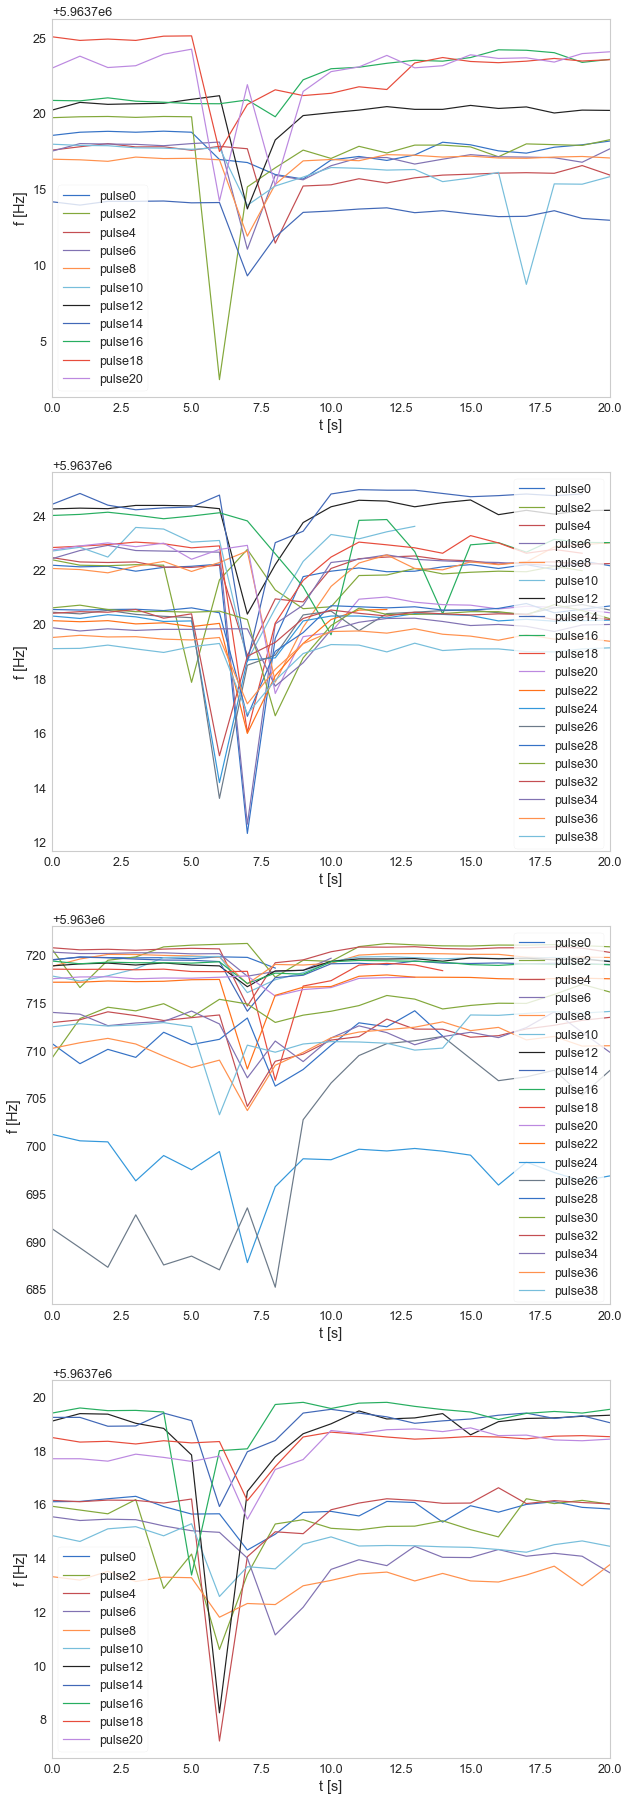

In [126]:
fig, ax = plt.subplots(len(dfqp), figsize=(10,8 * len(dfqs)))
for i,dfq in enumerate(dfqp):
    overplot_QMB_pulses(dfq, every=2, ax=ax[i])
    ax[i].set_xlim(0, 20)

In [68]:
fref = dfqp[0]['pulse0'][0]
fref

5963718.55

In [73]:
for pul in dfqp[0]:
    fshift = fref - dfqp[0][pul][0] 
    dfqp[0][pul]

0.0
-0.1299999998882413
-1.1699999999254942
-0.75
0.9699999997392297
1.8899999996647239
1.040000000037253
2.309999999590218
1.5699999993667006
-0.8700000001117587
0.5800000000745058
-1.0899999998509884
-1.6699999999254942
-1.6100000003352761
4.379999999888241
5.040000000037253
-2.3100000005215406
-5.730000000447035
-6.509999999776483
-4.7999999998137355
-4.440000000409782


## Get ∆m from ∆f

In [127]:
mL, dF = [], []
for dfq in dfqp:
    ml, df = coating_mass(dfq)
    mL.append((np.average(ml), np.std(ml)))
    dF.append((np.average(df), np.std(df)))

pulse19 is too short with upCut 10
pulse1 is too short with upCut 10
pulse1 is too short with upCut 10
pulse30 is too short with upCut 10


In [55]:
mL

[(4.155785430977826e-08, 2.522229878028453e-08),
 (3.2692745345981594e-08, 1.5903890806595604e-08),
 (3.6105485052470466e-08, 2.197589259804999e-08),
 (2.9079468565624418e-08, 2.2498150772570836e-08)]

In [56]:
dF

[(6.773999999929219, 4.111277660310774),
 (5.328974358904629, 2.5923623469228847),
 (5.885250000003725, 3.582104121554429),
 (4.740000000090471, 3.667234588067633)]

Text(0.5, 1.0, 'ALI+QMB position test')

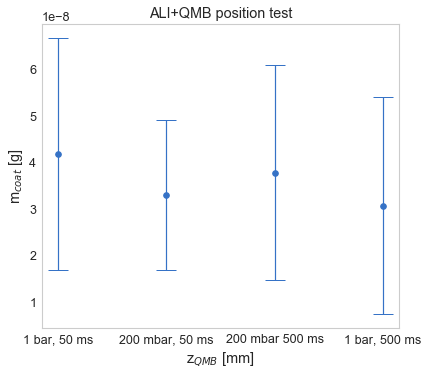

In [128]:
mmL = np.matrix(mL)
mdF = np.matrix(dF)
names = ['1 bar, 50 ms', '200 mbar, 50 ms', '200 mbar 500 ms', '1 bar, 500 ms']
plt.errorbar(names, mmL[:,0], mmL[:,1], fmt='o', capsize=10, mew=1)
plt.ylabel('m$_{coat}$ [g]')
plt.xlabel('z$_{QMB}$ [mm]')
# plt.xticks(zpos);
plt.title('ALI+QMB position test')

# ALI on QMC: toff repetition Ba(ClO$_4$)$_2$ 0.5 mM 

In [112]:
ali_path = '/Users/pabloherrero/sabat/ali_data/Ba(ClO4)2_shooting/ALI_QMB_test/repetition_toff/*'
qmb_path = '/Users/pabloherrero/sabat/qmc_data/ALI_QMB_BaClO42_test/repetition_toff/*'
qmbFiles = glob.glob(qmb_path)
qmbFiles.sort()
aliFiles = glob.glob(ali_path)
aliFiles.sort()

qmbFiles, aliFiles

(['/Users/pabloherrero/sabat/qmc_data/ALI_QMB_BaClO42_test/repetition_toff/RUN#00006_1bar_50ms.txt',
  '/Users/pabloherrero/sabat/qmc_data/ALI_QMB_BaClO42_test/repetition_toff/RUN#00007_200mbar_50ms.txt',
  '/Users/pabloherrero/sabat/qmc_data/ALI_QMB_BaClO42_test/repetition_toff/RUN#00008_200mbar_500ms.txt'],
 ['/Users/pabloherrero/sabat/ali_data/Ba(ClO4)2_shooting/ALI_QMB_test/repetition_toff/18052020_BaClO42_qmb_test1_1000mbar_50ms_20pulse',
  '/Users/pabloherrero/sabat/ali_data/Ba(ClO4)2_shooting/ALI_QMB_test/repetition_toff/18052020_BaClO42_qmb_test2_200mbar_50ms_20pulse',
  '/Users/pabloherrero/sabat/ali_data/Ba(ClO4)2_shooting/ALI_QMB_test/repetition_toff/18052020_BaClO42_qmb_test3_200mbar_50ms_20pulse'])

## Importing all data

In [113]:
dfps = [load_raw_ali_df(f) for f in aliFiles]
dfqs = [import_qmb_data(f) for f in qmbFiles]

## Split ALI file [2]

Appended pulses at 200 mbar, 500ms, (test3) to test 2 (200 mbar, 50 ms) by mistake: Split last 12 pulses in separate file

In [104]:
### Deleted the double file after splitting. Here just for illustration
aliFileSplit = '/Users/pabloherrero/sabat/ali_data/Ba(ClO4)2_shooting/ALI_QMB_test/repetition_toff/18052020_BaClO42_qmb_test23_200mbar_50ms_20pulse'

aliFileSplit, qmbFiles[2]

('/Users/pabloherrero/sabat/ali_data/Ba(ClO4)2_shooting/ALI_QMB_test/repetition_toff/18052020_BaClO42_qmb_test33_200mbar_50ms_20pulse',
 '/Users/pabloherrero/sabat/qmc_data/ALI_QMB_BaClO42_test/repetition_toff/RUN#00008_200mbar_500ms.txt')

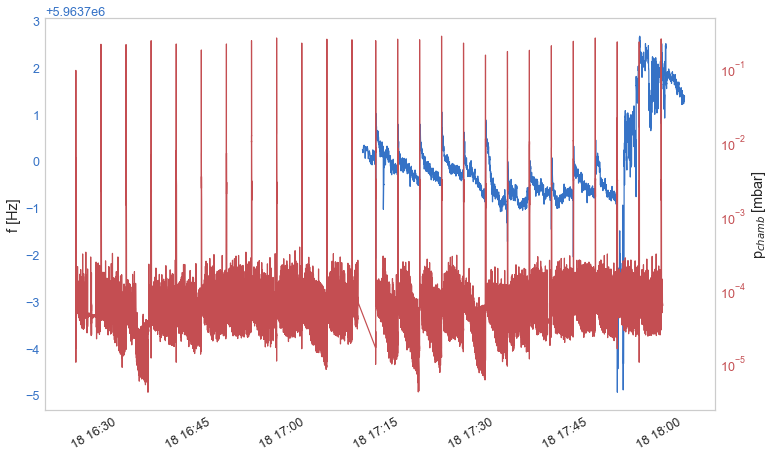

In [105]:
dfp = load_raw_ali_df(aliFilesSplit)
dfq = import_qmb_data(qmbFiles[2])
fig = plt.figure(figsize=(12,8))
plot_ali_qmb_pulses(dfp, dfq)

In [106]:
minAli = findTroughsFast(dfp)
minAli.shape, minAli

((26,), array([   100,  24103,  48106,  72109,  96111, 120114, 144117, 168126,
        192139, 216205, 240207, 264210, 269897, 290900, 311903, 332906,
        353909, 374912, 395915, 416918, 437920, 458923, 479926, 500929,
        521932, 542936]))

In [107]:
minQmb = qmb_troughs_asALI(dfq, dfp, minAli)
np.where(np.array(minQmb) > -3)
minQmb[12]

63

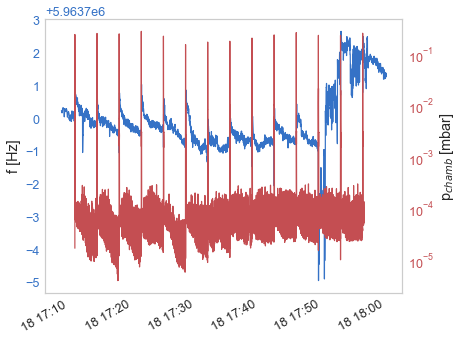

In [84]:
minAli[12]

plot_ali_qmb_pulses(dfp.iloc[minAli[12]:], dfq)

### So the split point is minAli[12]

In [99]:
dfp2 = dfp.iloc[minAli[12]:]
dfp2.datetime = dfp2.datetime.apply(lambda x: datetime.datetime.strftime(x, '%d/%m/%Y %H:%M:%S.%f'))
dfp2.to_csv('/Users/pabloherrero/sabat/ali_data/Ba(ClO4)2_shooting/ALI_QMB_test/repetition_toff/18052020_BaClO42_qmb_test33_200mbar_50ms_20pulse', index=False, sep='\t', decimal=',')

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [109]:
dfp3 = dfp.iloc[:minAli[12]+1]
dfp3.datetime = dfp3.datetime.apply(lambda x: datetime.datetime.strftime(x, '%d/%m/%Y %H:%M:%S.%f'))
dfp3.to_csv('/Users/pabloherrero/sabat/ali_data/Ba(ClO4)2_shooting/ALI_QMB_test/repetition_toff/18052020_BaClO42_qmb_test22_200mbar_50ms_20pulse', index=False, sep='\t', decimal=',')

In [111]:
load_raw_ali_df('/Users/pabloherrero/sabat/ali_data/Ba(ClO4)2_shooting/ALI_QMB_test/repetition_toff/18052020_BaClO42_qmb_test2_200mbar_50ms_20pulse')

,datetime,p_chamber,p_act,p_lock,p_pre-inj,t_valve,valve,time_on
0,2020-05-18 16:23:11.370,0.000018,0.00005,0.001,280.0,21.2,0,50
1,2020-05-18 16:23:11.380,0.000018,0.00005,0.001,280.0,21.2,0,50
2,2020-05-18 16:23:11.390,0.000018,0.00005,0.001,280.0,21.2,0,50
3,2020-05-18 16:23:11.400,0.000018,0.00005,0.001,280.0,21.2,0,50
4,2020-05-18 16:23:11.410,0.000018,0.00005,0.001,280.0,21.2,0,50
5,2020-05-18 16:23:11.420,0.000018,0.00005,0.001,280.0,21.2,0,50
6,2020-05-18 16:23:11.430,0.000018,0.00005,0.001,280.0,21.2,0,50
7,2020-05-18 16:23:11.440,0.000018,0.00005,0.001,280.0,21.2,0,50
8,2020-05-18 16:23:11.450,0.000018,0.00005,0.001,280.0,21.2,0,50
9,2020-05-18 16:23:11.460,0.000018,0.00005,0.001,280.0,21.2,0,50


## Drop QMB data until first injection

In [11]:
dfq_short = []
for dfp, dfq in zip(dfps, dfqs):
    minAli = findTroughsFast(dfp)
    firstP = dfp.datetime[minAli[0]]
    dfq_sh = dfq[dfq.timestamp >= firstP]
    dfq_sh.reset_index(drop=True, inplace=True)
    dfq_short.append(dfq_sh)

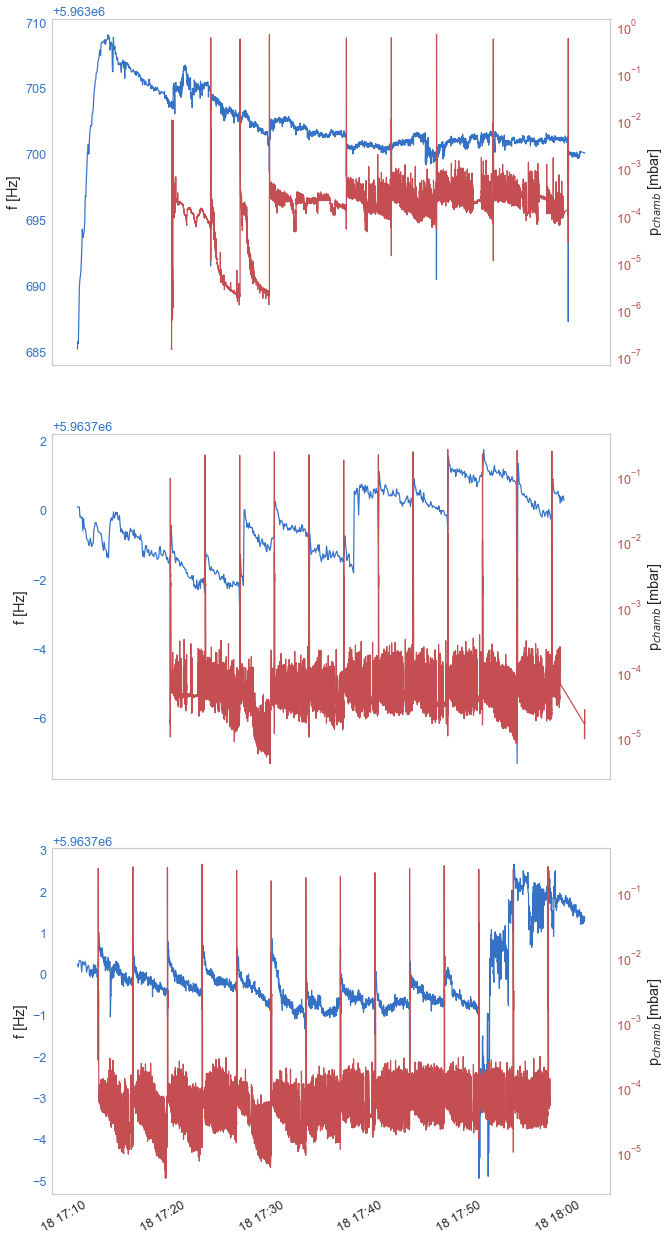

In [114]:
fig, ax = plt.subplots(len(dfqs), figsize=(10,8 * len(dfqs)))
for i,(dfp, dfq) in enumerate(zip(dfps, dfqs)):
    plot_ali_qmb_pulses(dfp, dfq, ax=ax[i])

## Extract QMB pulses

In [115]:
dfqp = []
for dfp, dfq in zip(dfps, dfqs):
    minAli = findTroughsFast(dfp)
    minQmb = qmb_troughs_asALI(dfq, dfp, minAli)
    dfqp.append(extractQMBPeaks(dfq, minQmb))

(0, 20)

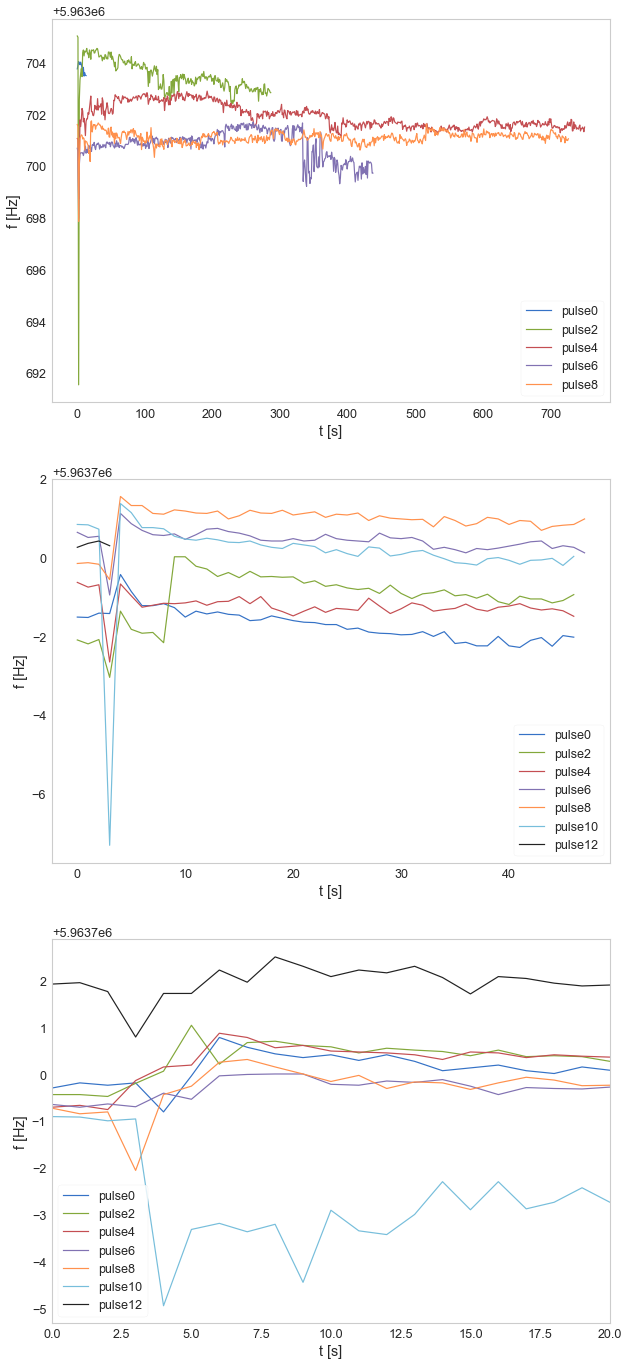

In [116]:
fig, ax = plt.subplots(len(dfqp), figsize=(10,8 * len(dfqs)))
for i,dfq in enumerate(dfqp):
    overplot_QMB_pulses(dfq, every=2, ax=ax[i])
plt.xlim(0, 20)

## Get ∆m from ∆f

In [117]:
mL, dF = [], []
for dfq in dfqp:
    ml, df = coating_mass(dfq)
    mL.append((np.average(ml), np.std(ml)))
    dF.append((np.average(df), np.std(df)))

pulse12 is too short with upCut 10


In [118]:
mL

[(3.1962955128863273e-08, 2.9435603798734826e-08),
 (7.203425696254565e-09, 1.3450639509826444e-08),
 (5.332666886868232e-09, 6.2119075852198185e-09)]

In [119]:
dF

[(5.209999999962747, 4.798039182855763),
 (1.1741666665766388, 2.1924699098096574),
 (0.8692307692164412, 1.012547902344568)]

Text(0.5, 1.0, 'ALI+QMB position test')

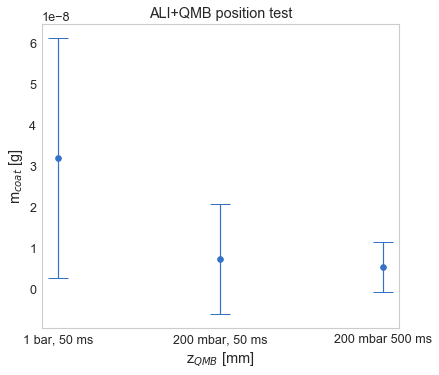

In [121]:
mmL = np.matrix(mL)
mdF = np.matrix(dF)
names = ['1 bar, 50 ms', '200 mbar, 50 ms', '200 mbar 500 ms']
plt.errorbar(names, mmL[:,0], mmL[:,1], fmt='o', capsize=10, mew=1)
plt.ylabel('m$_{coat}$ [g]')
plt.xlabel('z$_{QMB}$ [mm]')
# plt.xticks(zpos);
plt.title('ALI+QMB position test')